# AICON Walkthrough

*Florian Prill, Deutscher Wetterdienst (DWD), December 2025*

---


<div style="max-width: 100%;color:#696969;"><i>
DWD team for data-driven NWP: Roland Potthast, Jan Keller, Stefanie Hollborn, Nora Schenk, Thomas Deppisch, Nastaran Najari, Florian Prill, Tobias Göcke, Marek Jacob, Hendrik Reich, Sabrina Wahl, Sven Ulbrich
</i></div>
<p/>

<div style="max-width: 100%;color:#696969;"><i>
Disclaimer: All scripts, software packages and formats explained in this Jupyter Notebook are subject to change! 
The <a href="https://github.com/ecmwf/anemoi-graphs/pull/53">(first) AICON functionalities</a> were added to the Anemoi codebase in November 2024. The first version of the DWD software for AICON inference was completed at the end of March 2025.
</i></div>
<p/>

---

This Jupyter notebook has been uploaded to https://gitlab.dkrz.de/fprill/aicon-walkthrough/

## Introduction

There has been substantial progress in the field of data-driven weather forecasting. FourCastNet, Pangu-Weather, GraphCast, GenCast and Aurora (developed by NVIDIA, Huawei, Google DeepMind and Microsoft) are just a few examples.
At DWD, ML-based forecasts are seen as a complement to the global and regional ICON model for numerical weather prediction.

The DWD model **AICON** is based on Graph Neural Networks (GNNs). This approach was introduced to global weather prediction by [Keisler2022] and treats the Earth as a graph with nodes representing spatial locations.

In June 2024, DWD adopted the shared Anemoi codebase for its research and development. 
The **Anemoi Framework** is a collaborative European initiative driving the development of machine-learning–powered weather models across Europe. It underpins key systems including ECMWF’s Artificial Intelligence Forecasting System (AIFS), MetNorway’s Bris (which extends AIFS), and DWD’s AICON. Recognized with the EMS Technology Achievement Award 2025, Anemoi’s development is closely aligned with EUMETNET’s E‑AI program on Artificial Intelligence and Machine Learning in Weather, Climate and Environmental Application.

<figure style="text-align: right; width: 50%; margin-left: auto;">
  <img src="_static/aicon_global_spec_humidity_l101.png" alt="Specific humidity, ICON level 101" style="width: 100%;">
  <figcaption>Example of an AICON-Global forecast for specific humidity at the respective ICON vertical level 101
Source: <a href="https://www.dwd.de/DE/fachnutzer/forschung_lehre/numerische_wettervorhersage/nwv_aenderungen/_functions/DownloadBox_modellaenderungen/icon/pdf_2025/pdf_icon_03_09_2025.pdf?__blob=publicationFile&v=2">2025-09-03, Operationelles NWV-System Änderungsmitteilung.</a></figcaption>
</figure>


---

In this Jupyter notebook, we take a deep dive into AICON.

The Anemoi codebase for GNNs is built from various Github repositories [Lang2024]:
- [`anemoi-core`](https://github.com/ecmwf/anemoi-core): core packages that define the GNN graphs, the models and the driver code for training.
- [`anemoi-datasets`](https://github.com/ecmwf/anemoi-datasets): high-level interface for I/O operations, based on a YAML recipe files.
- [`anemoi-inference`](https://github.com/ecmwf/anemoi-inference): package for generation of ML-driven weather predictions
- other supporting repositories, eg. [`anemoi-transform`](https://github.com/ecmwf/anemoi-transform)

The framework builds upon established Python tools including PyTorch, Lightning, Hydra, Zarr, Xarray and earthkit.
See the documentation at https://anemoi.readthedocs.io for further info.
The GNN implementation is based on the `torch_geometric` ([PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/), PyG) library.


![Package logos](_static/logos.png)

## AICON model training

Installing the packages can be complicated. The exact versions of the packages also play an important role.
For this reason, the necessary [ingredients for AICON](https://gitlab.dkrz.de/aicon/anemoi/anemoi-dwd) are summarized here in a file `requirements.txt` and can be installed collectively using `pip`.

In [1]:
%%capture
%pip install --no-cache-dir -U -r ../requirements.txt

# List all the installed packages with their versions:
# (do not forget to remove the capture command if you want to see the output)
!pip freeze

In [2]:
print(*[l for l in open('../requirements.txt') if 'git' in l], end='')

-e git+https://github.com/ecmwf/anemoi-core.git@training-0.7.0#egg=anemoi-training[test]&subdirectory=training
 -e git+https://github.com/ecmwf/anemoi-core.git@models-0.10.0#egg=anemoi-models&subdirectory=models
 -e git+https://github.com/ecmwf/anemoi-core.git@graphs-0.7.2#egg=anemoi-graphs&subdirectory=graphs
 -e git+https://github.com/ecmwf/anemoi-datasets.git@0.5.28#egg=anemoi-datasets


Before we start, let's make some basic settings for this Jupyter notebook.

In [3]:
%load_ext autoreload
%autoreload 2

%load_ext mermaid_magic
%load_ext nb_js_diagrammers

Later on, we will work with GRIB2 datasets. GRIB is a compact binary format for gridded weather data. Field names in GRIB come from parameter codes that are translated using external code tables. Therefore, we need to set definition paths.

In [4]:
import socket
if socket.gethostname().startswith("gpnl"):
    %env ECCODES_PYTHON_USE_FINDLIBS=0
    %env ECCODES_DEFINITION_PATH=/hpc/sw/eccodes/definitions/release/2.44.0/definitions.edzw:/hpc/sw/eccodes/definitions/release/2.44.0/definitions
else:
    %env ECCODES_DEFINITION_PATH=/mnt/data/ai/icon_vert_interp/definitions.edzw-2.35.0/release/2.35.0/definitions.edzw:/usr/share/eccodes/definitions

env: ECCODES_PYTHON_USE_FINDLIBS=0
env: ECCODES_DEFINITION_PATH=/hpc/sw/eccodes/definitions/release/2.44.0/definitions.edzw:/hpc/sw/eccodes/definitions/release/2.44.0/definitions


### Driver code

In the past months the AICON implementation (for global forecasts) has already entered the `main` versions of the respective Anemoi repositories. 
The [AICON integration test](https://github.com/ecmwf/anemoi-core/blob/main/training/tests/integration/aicon/test_cicd_aicon_04_icon-dream_medium.yaml) would be a good starting point to learn about the setup.
However, we plan to go into more detail here and we begin with a short explanation of the driver code necessary for **AICON training**.

First, we load a [YAML configuration](test_aicon_01.yaml). YAML is an easy-to-read data format commonly used for configuration files.
We will discuss some details of the YAML configuration below. For now, we will accept the settings as they are.

In [5]:
config_filename = "test_aicon_01.yaml"

In [6]:
import os, hydra
import anemoi.training

os.environ["ANEMOI_CONFIG_PATH"] = os.path.join(os.path.dirname(anemoi.training.__file__), "config")
with hydra.initialize(version_base=None, config_path="./"):
    config = hydra.compose(config_name=config_filename)

We use this to construct an Anemoi trainer object. Running the driver code in an interactive Jupyter notebook requires a slight modification (`JupyterNotebookStrategy`), which allows us to select a notebook-compatible strategy.

In [7]:
from anemoi.training.train.train import AnemoiTrainer
trainer = AnemoiTrainer(config)

class JupyterNotebookStrategy(str):
    def __init__(self, value):
        self.global_rank = 0

trainer.strategy = JupyterNotebookStrategy("auto")

The trainer uses the environment variable `ANEMOI_BASE_SEED` to initialize a pseudorandom number generator so that it produces a repeatable initialization of weights:

In [8]:
os.environ['ANEMOI_BASE_SEED'] = "42"

As a small technical addition, we are implementing a “live logger,” i.e., a class that plots the history of the loss function without additional tools.

In [9]:
import matplotlib.pyplot as plt
from pytorch_lightning.loggers import Logger

class GraphicalLiveLogger(Logger):
    def __init__(self, interval=10):
        super().__init__()
        self.metric_name = "train_weighted_mse_loss_step"
        self.metrics_history = []

    @property 
    def name(self): return "LiveLogger"
    @property 
    def version(self): return "0.1"

    def log_hyperparams(self, *args, **kwargs): pass

    def log_metrics(self, metrics, step):
        self.metrics_history.append((step, metrics))

    def finalize(self, status):
        steps, values = zip(*[(s,m[self.metric_name]) for s,m in self.metrics_history if self.metric_name in m])
        plt.figure(figsize=(8,4));
        plt.plot(steps, values, 'o-', ms=2, label="AICON", color="red")
        plt.title(f"{self.metric_name} over steps"); plt.xlabel("Step"); plt.ylabel(self.metric_name)
        plt.grid(True); plt.legend(); plt.show()

trainer.model.logger_enabled = True
trainer.loggers = GraphicalLiveLogger()

Seed set to 42000
/shared/data/fprill/aicon_walkthrough/venv/src/anemoi-datasets/src/anemoi/datasets/data/forwards.py:517: UserWarning: The behaviour of Join.collect_supporting_arrays() is not well defined
  warnings.warn(f"The behaviour of {self.__class__.__name__}.collect_supporting_arrays() is not well defined")
/shared/data/fprill/aicon_walkthrough/venv/src/anemoi-datasets/src/anemoi/datasets/data/forwards.py:517: UserWarning: The behaviour of Join.collect_supporting_arrays() is not well defined
  warnings.warn(f"The behaviour of {self.__class__.__name__}.collect_supporting_arrays() is not well defined")


Now we can perform a short training run for the neural network:

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                 ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ AnemoiModelInterface │  443 K │ train │     0 │
│ 1 │ loss    │ WeightedMSELoss      │      0 │ train │     0 │
│ 2 │ metrics │ ModuleDict           │      0 │ train │     0 │
└───┴─────────┴──────────────────────┴────────┴───────┴───────┘

Trainable params: 443 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 443 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 102                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/shared/data/fprill/aicon_walkthrough/venv/lib64/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:378: You have overridden `on_after_batch_transfer` in `LightningModule` but have passed in a `LightningDataModule`. It will use the implementation from `LightningModule` instance.
/shared/data/fprill/aicon_walkthrough/venv/src/anemoi-training/training/src/anemoi/training/losses/scaler_tensor.py:553: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:355.)
  x_subset = x[subset_indices] if subset_indices is not None else x
/shared/data/fprill/aicon_walkthrough/venv/src/anemoi-training/training/src/anemoi/training/losses/scaler_tensor.py:57

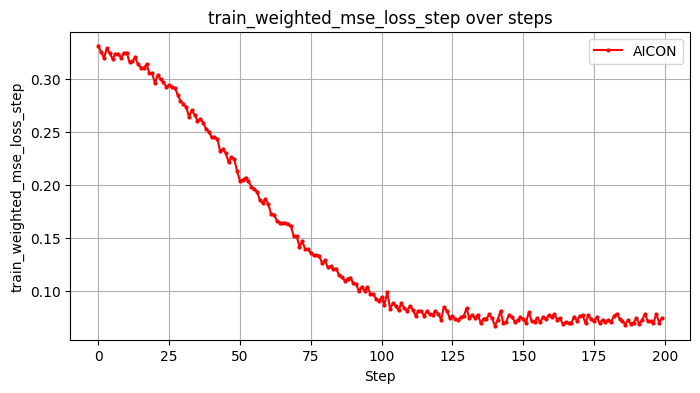

In [10]:
trainer.train()

Done! Let us examine which objects and models were involved in this training.

### Training datasets and variables

At this point, we don't want to devote too much time to describing the Anemoi training setup, eg. the data range, the optimizer settings, the epochs limit etc. Instead, for these general settings, we refer to [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/) or the [documentation for the Anemoi training setup](https://anemoi.readthedocs.io/projects/training/en/stable/user-guide/configuring.html).
From a "black box" perspective, the above test run has consumed various data files, and created a weights file ("checkpoint").

![Anemoi overview](_static/anemoi_overview.png)

Almost all of these files are provided as config parameters in the YAML file `config_filename`:

In [11]:
from omegaconf import OmegaConf
cfg = OmegaConf.load(config_filename)

In [12]:
print(f"""Input data:

ICON mesh (NetCDF):
{cfg.graph.nodes.icon_mesh.node_builder.grid_filename=}

Training interval:
{cfg.dataloader.training.start=} ... {cfg.dataloader.training.end=}
""")

# data files: 
# print('\n'.join([file for file in cfg.dataloader.training.join]))

# ---

print(f"""Output directories:

Directory with checkpoint files:
{cfg.hardware.paths.checkpoints=}

Log files (including MLFlow):
{cfg.hardware.paths.logs.base=}
""")

Input data:

ICON mesh (NetCDF):
cfg.graph.nodes.icon_mesh.node_builder.grid_filename='/shared/data/fe1ai/ml-datasets/structure/01_aicon-graph-files/icon_grid_0026_R03B07_G.nc'

Training interval:
cfg.dataloader.training.start='2022-01-01T00:00:00' ... cfg.dataloader.training.end='2022-03-03T00:00:00'

Output directories:

Directory with checkpoint files:
cfg.hardware.paths.checkpoints='output_training/checkpoint/'

Log files (including MLFlow):
cfg.hardware.paths.logs.base='output_training/mrl3/logs/'



The subdirectories denoting the output of the current run are auto-generated, if not set in the configuration (for the continuation of runs):

- The `run_id` is a unique identifier associated with a specific training run.
- Additionally, an experiment is associated with a namespace identifier `experiment_name`. This is used by experiment tracking systems, such as [MLflow](https://mlflow.org/).

In [13]:
print(f"""Unique run ID:
{trainer.run_id=}
            
Experiment namespaces:
{trainer.config.diagnostics.log.mlflow.experiment_name=}
""")

Unique run ID:
trainer.run_id='0210d057-147f-4d04-8d3f-df4b50044024'

Experiment namespaces:
trainer.config.diagnostics.log.mlflow.experiment_name='test'



To understand the meteorological input data, it is worthwhile to inspect a single data file. AICON consumes **gridded reanalysis data**, i.e. a global, consistent representation of the Earth's (averaged) weather conditions. These datasets are the result of the **ICON DREAM reanalysis** (ICON DREAM = Dual resolution Reanalysis for Emulators, Applications and Monitoring [DWD2024]) and have been converted into the Zarr format. [Zarr](https://zarr.readthedocs.io/) is an open-source format for storing large multidimensional arrays in chunked, compressed files optimized for parallel access.

In [14]:
import xarray
datafile = cfg.dataloader.training.join[0]
xarray.open_zarr(datafile, consolidated=False)

<xarray.Dataset> Size: 3GB
Dimensions:     (variable: 84, time: 724, ensemble: 1, cell: 11520)
Dimensions without coordinates: variable, time, ensemble, cell
Data variables:
    count       (variable) float64 672B dask.array<chunksize=(84,), meta=np.ndarray>
    data        (time, variable, ensemble, cell) float32 3GB dask.array<chunksize=(1, 84, 1, 11520), meta=np.ndarray>
    dates       (time) datetime64[s] 6kB dask.array<chunksize=(724,), meta=np.ndarray>
    has_nans    (variable) object 672B dask.array<chunksize=(84,), meta=np.ndarray>
    latitudes   (cell) float64 92kB dask.array<chunksize=(11520,), meta=np.ndarray>
    longitudes  (cell) float64 92kB dask.array<chunksize=(11520,), meta=np.ndarray>
    maximum     (variable) float64 672B dask.array<chunksize=(84,), meta=np.ndarray>
    mean        (variable) float64 672B dask.array<chunksize=(84,), meta=np.ndarray>
    minimum     (variable) float64 672B dask.array<chunksize=(84,), meta=np.ndarray>
    squares     (variable) float64 672B dask.array<chunksize=(84,), meta=np.ndarray>
    stdev       (variable) float64 672B dask.array<chunksize=(84,), meta=np.ndarray>
    sums        (variable) float64 672B dask.array<chunksize=(84,), meta=np.ndarray>
Attributes: (12/30)
    allow_nans:              False
    attribution:             Deutscher Wetterdienst
    constant_fields:         []
    data_request:            {'area': [None, None, None, None], 'grid': None,...
    description:             Test Dataset ICON DREAM Global reanalysis, 13 km...
    end_date:                2022-06-30T18:00:00
    ...                      ...
    total_size:              2028052523
    uuid:                    9ceba822-9940-499b-ab19-99c772561d94
    variables:               ['P_101', 'P_108', 'P_112', 'P_119', 'P_120', 'P...
    variables_metadata:      {'P_101': {'mars': {'date': 20220101, 'levelist'...
    variables_with_nans:     []
    version:                 0.30

From this result we can see that different fields from various levels are combined to form the **feature vector** of the model.
We can also directly access the dataset using the `zarr` Python package and separate variable names and levels:

In [15]:
from jupyter_utils import split_string, parse_shortname_def, parse_name_def, find_long_name_by_shortname
import zarr

zarr_group_in = zarr.open(datafile, mode="r")
var_list_in = list(zarr_group_in.attrs["variables"])

# get a unique list of GRIB2 shortNames:
var_data = [split_string(var)[0] for var in var_list_in]
vars_in = sorted( list( set(var_data) ) )

# get a list of levels for each variale:
for varname in vars_in:
    level_data = [
        [
            result[1]
            for var in var_list_in
            if (result := split_string(var))[0] == varname
        ]
        for varname in vars_in
    ]

# get GRIB2 info on the variable:
defpath = os.environ["ECCODES_DEFINITION_PATH"].split(":")
grib2_dict = [(parse_shortname_def(f"{path}/grib2/shortName.def"), parse_name_def(f"{path}/grib2/name.def")) for path in defpath]

data = {
    'shortName': vars_in,
    'Name':  [find_long_name_by_shortname(grib2_dict, v) for v in vars_in],
    'Levels': level_data
}

# print as a table:
import pandas as pd
from IPython.display import display
from jupyter_utils import pandas_table_style
display( pd.DataFrame(data).style.set_table_styles(pandas_table_style) )

,shortName,Name,Levels
0,P,Pressure,"[101, 108, 112, 119, 120, 49, 57, 64, 70, 75, 79, 86, 91, 96]"
1,QV,Specific Humidity,"[101, 108, 112, 119, 120, 49, 57, 64, 70, 75, 79, 86, 91, 96]"
2,T,Temperature,"[101, 108, 112, 119, 120, 49, 57, 64, 70, 75, 79, 86, 91, 96]"
3,U,U-Component of Wind,"[101, 108, 112, 119, 120, 49, 57, 64, 70, 75, 79, 86, 91, 96]"
4,V,V-Component of Wind,"[101, 108, 112, 119, 120, 49, 57, 64, 70, 75, 79, 86, 91, 96]"
5,W,Vertical Velocity (Geometric) (w),"[101, 108, 112, 119, 120, 49, 57, 64, 70, 75, 79, 86, 91, 96]"


Assuming a standard atmosphere and using ICON's list of **SLEVE coordinate level heights**, we can visualize this together with the currently used AIFS pressure levels from ECMWF [Lang2024] as follows:

In [16]:
# ICON output of the SLEVE coordinate setup:
vct_a = [
    75000.000, 73420.604, 71869.610, 70328.192, 68805.917, 67302.897, 65819.234, 64355.018, 62910.329, 61485.239,
    60079.812, 58694.107, 57328.172, 55982.053, 54655.788, 53349.411, 52062.951, 50796.435, 49549.882, 48323.311,
    47116.737, 45930.172, 44763.626, 43617.107, 42490.621, 41384.171, 40297.761, 39231.393, 38185.067, 37158.783,
    36152.542, 35166.342, 34200.183, 33254.064, 32327.985, 31421.947, 30535.948, 29669.993, 28824.082, 27998.221,
    27192.413, 26406.667, 25640.990, 24895.393, 24169.889, 23463.917, 22770.331, 22096.568, 21435.487, 20795.107,
    20175.457, 19576.575, 18998.498, 18441.271, 17908.405, 17400.463, 16920.113, 16467.114, 16039.909, 15637.031,
    15257.093, 14898.789, 14560.888, 14242.227, 13933.170, 13633.170, 13333.170, 13033.170, 12733.170, 12433.170,
    12133.170, 11833.170, 11533.170, 11233.170, 10933.170, 10633.170, 10333.170, 10033.170, 9733.170, 9433.170,
    9133.170, 8833.170, 8533.170, 8233.170, 7933.170, 7633.170, 7333.170, 7033.170, 6733.170, 6433.170,
    6133.170, 5833.170, 5533.170, 5233.170, 4933.170, 4633.170, 4333.170, 4033.170, 3735.917, 3448.582,
    3171.241, 2903.980, 2646.890, 2400.076, 2163.652, 1937.746, 1722.498, 1518.070, 1324.640, 1142.413,
    971.624, 812.540, 665.478, 530.811, 408.988, 300.565, 206.253, 126.999, 64.166, 20.000, 0.000
]

# AIFS:
import numpy as np
pressure_levels = np.array([50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000])

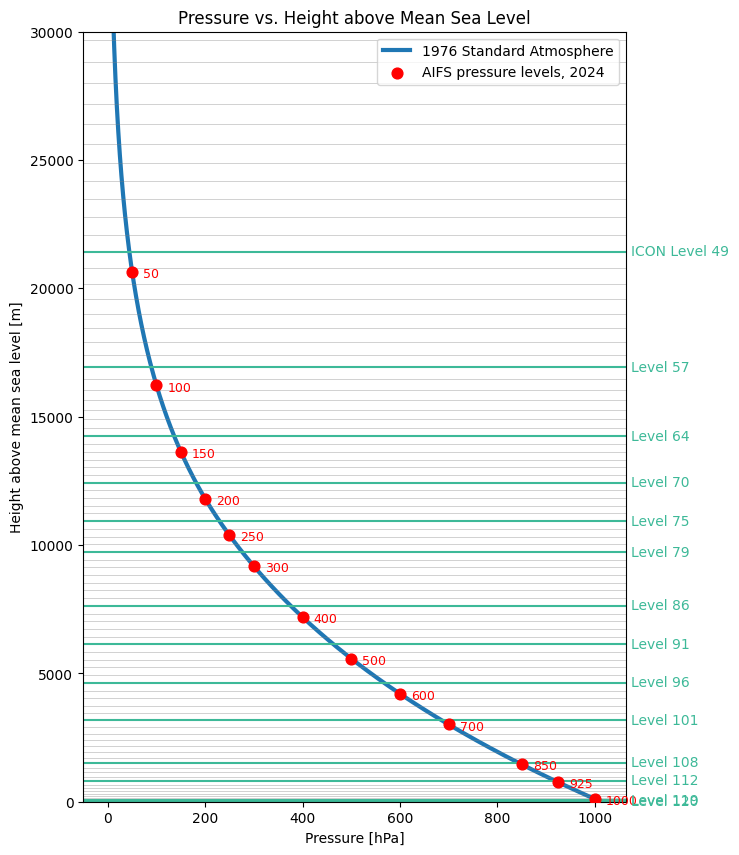

In [17]:
import matplotlib.transforms as mtransforms
import ussa1976

heights = np.arange(0, 100001, 100)
ds = ussa1976.compute(z=heights)
pressure_hPa = ds.p.values / 100.0
altitude_m = ds.z.values

altitude_marks = np.interp(pressure_levels, pressure_hPa[::-1], altitude_m[::-1])

levels_in = sorted(level_data[0])
highlight_indices = [i-1 for i in levels_in]
color_sel = '#3db998'

fig, ax = plt.subplots(figsize=(7, 10))
ax.plot(pressure_hPa, altitude_m, linewidth=3)
ax.scatter(pressure_levels, altitude_marks, color='red', marker='o', s=60, zorder=5, label='AIFS pressure levels, 2024')

for p, h in zip(pressure_levels, altitude_marks):
    ax.annotate(f'{int(p)}', (p, h), textcoords="offset points", xytext=(8, -4), ha='left', fontsize=9, color='red')

topmost_idx = max(highlight_indices, key=lambda i: vct_a[i])
for idx, y in enumerate(vct_a):
    if idx in highlight_indices:
        ax.axhline(y, color=color_sel, linestyle='-', linewidth=1.5)
        trans = mtransforms.blended_transform_factory(ax.transAxes, ax.transData)
        label = f'ICON Level {idx+1}' if idx == topmost_idx else f'Level {idx+1}'
        ax.annotate(label, xy=(1.01, y), xycoords=trans, va='center', ha='left', fontsize=10, color=color_sel, clip_on=False)
    else:
        ax.axhline(y, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)  # Thin gray line

ax.set_xlabel('Pressure [hPa]')
ax.set_ylabel('Height above mean sea level [m]')
ax.set_title('Pressure vs. Height above Mean Sea Level')
ax.grid(False)
ax.set_ylim(0, 30000)
ax.legend(["1976 Standard Atmosphere", "AIFS pressure levels, 2024"], loc='upper right', fontsize=10)
fig.savefig("AICON_levels.pdf", bbox_inches="tight")
plt.show()

The next input dataset contains the "forcings". **Forcing variables** are input variables that provide external information to the model but are not predicted by the model itself.

In [18]:
import zarr
forcings_file = cfg.dataloader.training.join[1]
zarr_group_in = zarr.open(forcings_file, mode="r")

var_list_in = list(zarr_group_in.attrs["variables"])

from pprint import pprint
pprint(var_list_in)

['EMIS_RAD',
 'FR_LAKE',
 'FR_LAND',
 'HSURF',
 'SSO_GAMMA',
 'SSO_SIGMA',
 'SSO_STDH',
 'SSO_THETA',
 'Z0',
 'cos_julian_day',
 'cos_latitude',
 'cos_local_time',
 'cos_longitude',
 'insolation',
 'sin_julian_day',
 'sin_latitude',
 'sin_local_time',
 'sin_longitude']


If you want to create your own custom Zarr datasets, the `anemoi-datasets` package provides the command-line tool

```bash
anemoi-datasets -d create my-data.yaml test_out.zarr
```

However, the specific settings of the YAML configuration file, named `my-data.yaml`, will not be covered in this specific Jupyter notebook.

### Checkpoint files

The **checkpoint directory** contains both, a checkpoint for training continuation (`last.ckpt`) and the inference checkpoint for prediction runs (`inference-last.ckpt`). In PyTorch Lightning, `last.ckpt` is the latest checkpoint file, but older checkpoints can be retained. Furthermore, Anemoi allows fine-grained control over the checkpointing frequency:

In [19]:
print(OmegaConf.to_yaml(cfg.diagnostics.checkpoint))

every_n_minutes:
  save_frequency: 30
  num_models_saved: 3
every_n_epochs:
  save_frequency: 1
  num_models_saved: -1
every_n_train_steps:
  save_frequency: 20
  num_models_saved: 0



The inference checkpoint `inference-last.ckpt` can be processed by an [AICON-specific standalone tool](https://gitlab.dkrz.de/dwd-ki-zentrum/apps/aicon-anemoi) to produce ML-driven forecasts, see below. This implies that all necessary information is contained as meta-data:

In [20]:
import zipfile, json

inference_ckpt_filename = f"{cfg.hardware.paths.checkpoints}{trainer.run_id}/inference-last.ckpt"
print(f"Checkpoint file: {inference_ckpt_filename}")

# extract meta-data from checkpoint:
with zipfile.ZipFile(inference_ckpt_filename, "r") as f:
    json_file = next(
        (s for s in f.namelist() if os.path.basename(s) == "ai-models.json"), None
    )
    metadata = json.load(f.open(json_file, "r"))

print(f"""Inference checkpoint meta-data:
      
variables = {metadata['dataset']['variables']}
number_of_grid_points = {metadata['dataset']['shape'][-1]}
refinement = {metadata['config']['graph']['nodes']['icon_mesh']['node_builder']['max_level_multimesh']}
model_timestep = {metadata['config']['data']['timestep']}
""")

Checkpoint file: output_training/checkpoint/0210d057-147f-4d04-8d3f-df4b50044024/inference-last.ckpt
Inference checkpoint meta-data:

variables = ['P_101', 'P_108', 'P_112', 'P_119', 'P_120', 'P_49', 'P_57', 'P_64', 'P_70', 'P_75', 'P_79', 'P_86', 'P_91', 'P_96', 'QV_101', 'QV_108', 'QV_112', 'QV_119', 'QV_120', 'QV_49', 'QV_57', 'QV_64', 'QV_70', 'QV_75', 'QV_79', 'QV_86', 'QV_91', 'QV_96', 'T_101', 'T_108', 'T_112', 'T_119', 'T_120', 'T_49', 'T_57', 'T_64', 'T_70', 'T_75', 'T_79', 'T_86', 'T_91', 'T_96', 'U_101', 'U_108', 'U_112', 'U_119', 'U_120', 'U_49', 'U_57', 'U_64', 'U_70', 'U_75', 'U_79', 'U_86', 'U_91', 'U_96', 'V_101', 'V_108', 'V_112', 'V_119', 'V_120', 'V_49', 'V_57', 'V_64', 'V_70', 'V_75', 'V_79', 'V_86', 'V_91', 'V_96', 'W_101', 'W_108', 'W_112', 'W_119', 'W_120', 'W_49', 'W_57', 'W_64', 'W_70', 'W_75', 'W_79', 'W_86', 'W_91', 'W_96', 'EMIS_RAD', 'FR_LAKE', 'FR_LAND', 'HSURF', 'SSO_GAMMA', 'SSO_SIGMA', 'SSO_STDH', 'SSO_THETA', 'Z0', 'cos_julian_day', 'cos_latitude', 'co


Note, however, that Anemoi's method to store the checkpoints is to save only the model's `state_dict`, which contains just the learned parameters. Therefore, the model structure, including class definitions and functions, still needs to be available. This dependency is met by encapsulating the Python virtual environment in a container image.

## Hidden mesh / multi-mesh definition

The main feature of the AICON model (apart from its training dataset) is its graph construction directly based on ICON's triangular meshes.

To understand the AICON hidden mesh definition it is first useful to have a look at the NetCDF grid file itself. This is a copy of the "classical" ICON grid [Prill2024], augmented by two additional fields, `refinement_level_v`, `refinement_level_c`. These are created during ICON's hierarchical grid construction process.

In [21]:
grid_filename = cfg.graph.nodes.icon_mesh.node_builder.grid_filename
print(f"{grid_filename=}")

from netCDF4 import Dataset
netcdf_grid = Dataset(grid_filename, 'r')

print(f"number_of_grid_used: {getattr(netcdf_grid, 'number_of_grid_used')}")
for var_name, var in netcdf_grid.variables.items():
    if var_name.startswith("refinement"):
        sizes = [len(netcdf_grid.dimensions[d]) for d in var.dimensions]
        print(f"Name: {var_name}, Dimensions: {var.dimensions}, Datatype: {var.dtype}, Size: {sizes}")
        
vlat = np.rad2deg(netcdf_grid.variables["vlat"][:])
vlon = np.rad2deg(netcdf_grid.variables["vlon"][:])
reflvl_v = netcdf_grid.variables["refinement_level_v"][:]

grid_filename='/shared/data/fe1ai/ml-datasets/structure/01_aicon-graph-files/icon_grid_0026_R03B07_G.nc'
number_of_grid_used: 26
Name: refinement_level_v, Dimensions: ('vertex',), Datatype: int32, Size: [1474562]
Name: refinement_level_c, Dimensions: ('cell',), Datatype: int32, Size: [2949120]


The `refinement_level_v` index can be used to define evenly distributed sets of varying density.

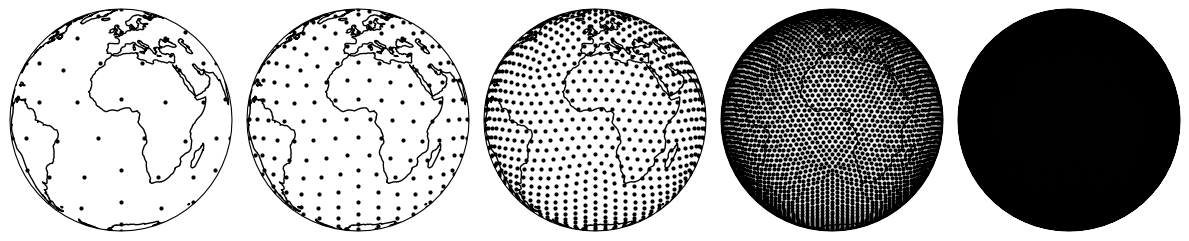

In [22]:
import cartopy.crs as ccrs

fig, axs = plt.subplots(1, 5, figsize=(12, 4),
                        subplot_kw={'projection': ccrs.Orthographic(central_longitude=0, central_latitude=0)})

for i in range(5):
    mask = (reflvl_v <= i)
    axs[i].coastlines()
    axs[i].plot(vlon[mask], vlat[mask], 'ko', transform=ccrs.PlateCarree(), markersize=2)

plt.tight_layout()
plt.show()

Each refinement level corresponds to a graph consisting of these points.

The **hidden mesh** of the AICON/Anemoi processor will be constructed as the union of these subgraphs. It therefore mixes long-range and short-range edges similar to the GraphCast multi-mesh (see the publication "GraphCast: Learning skillful medium-range global weather forecasting", [Lam2022]).

In [23]:
max_level_multimesh = cfg.graph.nodes.icon_mesh.node_builder.max_level_multimesh

print(f"{max_level_multimesh=}")
print(f"number of hidden mesh nodes: {np.sum(reflvl_v <= max_level_multimesh)=}")

max_level_multimesh=3
number of hidden mesh nodes: np.sum(reflvl_v <= max_level_multimesh)=5762


The number of hidden mesh nodes therefore corresponds to the number of vertices in an *RnBk* ICON grid, where *n* denotes the ICON grid root index and k := `max_level_multimesh`. We can calculate its number of vertices as follows (see, eg., [Prill2024] for the formula):

In [24]:
n = getattr(netcdf_grid, 'grid_root')
k = max_level_multimesh

# no. of vertices:
print(f"{10 * n**2 * 4**k + 2=} hidden mesh vertices")

10 * n**2 * 4**k + 2=5762 hidden mesh vertices


 Finally, the set of edges in the hidden mesh is equivalent to the union of all edges in the coarse-to-fine level hierarchy `RnB0` ... `RnBk`. We can verify this with the formula for icosahedral meshes, $n_e = 30 n^2 4^k$. Note that the hidden mesh is an undirected graph, which is modelled as a directed graph with exactly twice the number of edges.
This result is identical to the number of hidden mesh edges that was generated in our AICON example:

In [25]:
n = getattr(netcdf_grid, 'grid_root')
nedges_total = 0

for k in range(max_level_multimesh+1):
	# no. of edges for level k:
	nedges_total += 30 * n**2 * 4**k
print(f"calculated number of edges: {2*nedges_total=}")

edges = trainer.graph_data.edge_stores[0].edge_index.numpy().T
print(f"number of edges in the AICON multi-mesh: {edges.shape[0]}")

calculated number of edges: 2*nedges_total=45900
number of edges in the AICON multi-mesh: 45900


For AICON there exist two classes in Anemoi that create the spatial graph nodes (discrete points) for the AICON model, `ICONCellGridNodes` and `ICONMultimeshNodes`. These are activated in the YAML setup as follows:

In [26]:
print(OmegaConf.to_yaml(cfg.graph.nodes))

# find corresponding source code file:
import importlib, inspect
classname_icon_node_builder = cfg.graph.nodes.hidden.node_builder._target_
module = importlib.import_module("anemoi.graphs.nodes")
cls = getattr(module, "ICONMultimeshNodes")
path = inspect.getfile(cls)

print(f"Implementation: can be found in {path[path.rfind('src'):]}.")

icon_mesh:
  node_builder:
    _target_: anemoi.graphs.nodes.ICONNodes
    name: icon_grid_0026_R03B07_G
    grid_filename: /shared/data/fe1ai/ml-datasets/structure/01_aicon-graph-files/icon_grid_0026_R03B07_G.nc
    max_level_multimesh: 3
    max_level_dataset: 3
data:
  node_builder:
    _target_: anemoi.graphs.nodes.ICONCellGridNodes
    icon_mesh: icon_mesh
  attributes: ${graph.attributes.nodes}
hidden:
  node_builder:
    _target_: anemoi.graphs.nodes.ICONMultimeshNodes
    icon_mesh: icon_mesh

Implementation: can be found in src/anemoi/graphs/nodes/builders/from_icon.py.


The `ICONCellGridNodes` object describes the ICON data mesh, ie. with the data locations at the cell circumcenters.
Here, we focus on the hidden mesh object `anemoi.graphs.nodes.ICONMultimeshNodes` which can be visualized as follows:

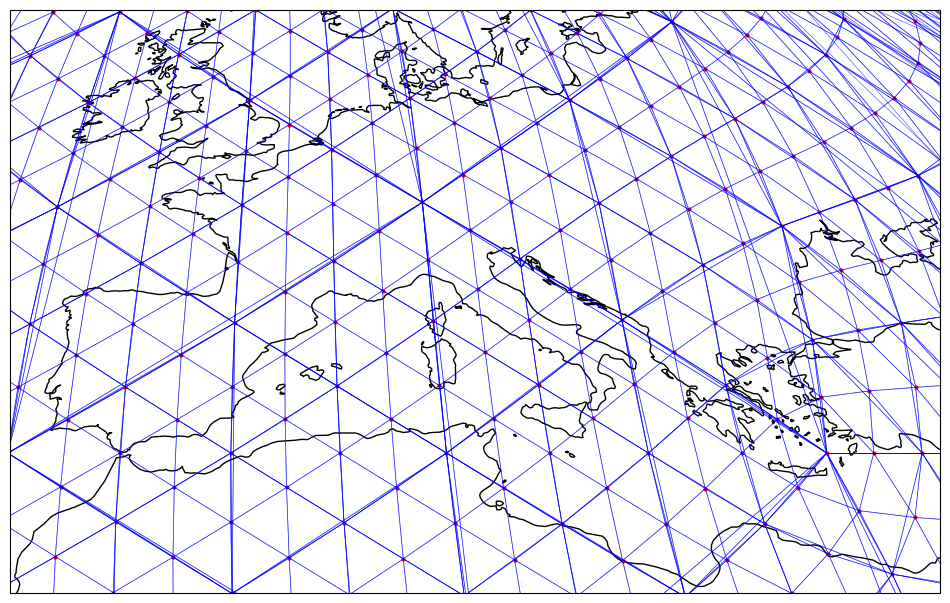

In [27]:
from matplotlib.collections import LineCollection

plt.figure(figsize=(12, 8))

# Extract coordinates and edges
coords = np.rad2deg(trainer.graph_data.node_stores[0]["x"].numpy())
edges = trainer.graph_data.edge_stores[0].edge_index.numpy().T

# Create segments as a NumPy array
segments = coords[edges]

# Set up Cartopy map
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=0, central_latitude=0))
ax.set_extent([-10, 30, 30, 60], crs=ccrs.PlateCarree())
ax.coastlines()

# Plot nodes and edges
ax.plot(coords[:, 0], coords[:, 1], 'ro', transform=ccrs.PlateCarree(), markersize=2)
lc = LineCollection(segments, colors='b', linewidths=0.5, alpha=0.6, transform=ccrs.PlateCarree())
ax.add_collection(lc)

plt.show()

 We generate this plot a second time. This time we generate edge-vertex relations level-wise in order to make the coarser levels more visible:

In [28]:
from torch_geometric.data import HeteroData
from anemoi.graphs.create import GraphCreator
from anemoi.training.schemas.base_schema import convert_to_omegaconf

graph_config = convert_to_omegaconf(trainer.config).graph
graph = HeteroData()
graph = GraphCreator(config=graph_config).update_graph(graph)

edge_vertices_fine = np.asarray(netcdf_grid.variables["edge_vertices"][:] - 1, dtype=np.int64).transpose()
cell_vertices_fine = np.asarray(netcdf_grid.variables["vertex_of_cell"][:] - 1, dtype=np.int64).transpose()

multi_mesh = graph["icon_mesh"]["_multi_mesh"]
(edge_vertices, cell_vertices) = multi_mesh._get_hierarchy_of_icon_edge_graphs(
            edge_vertices_fine=edge_vertices_fine,
            cell_vertices_fine=cell_vertices_fine,
            reflvl_vertex=reflvl_v,
        )

coords_fine = np.stack((vlon, vlat), axis=1)

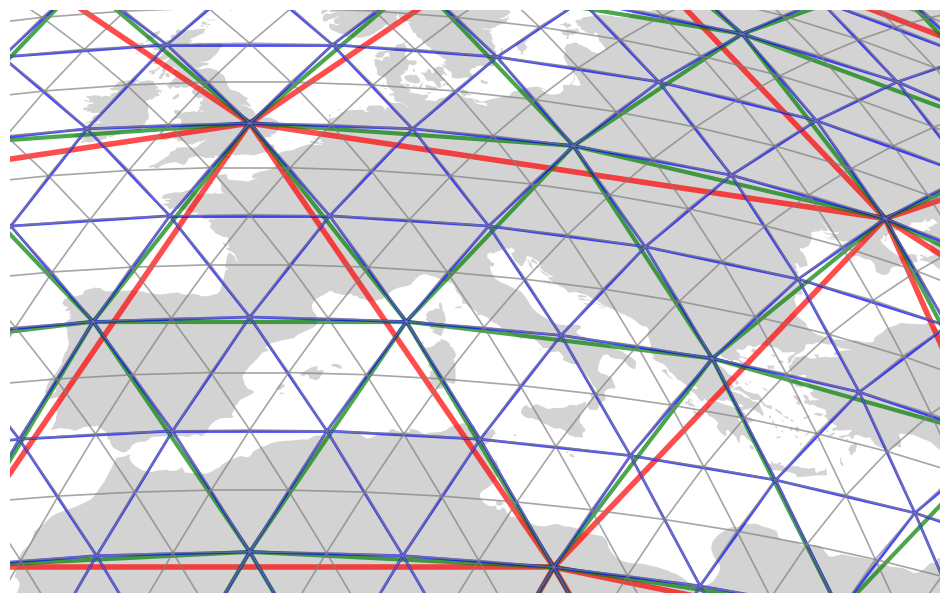

In [29]:
from matplotlib.collections import LineCollection
import cartopy.feature as cfeature

plt.figure(figsize=(12, 8))

ax = plt.axes(projection=ccrs.Orthographic(central_longitude=0, central_latitude=0))
ax.set_extent([-10, 30, 30, 60], crs=ccrs.PlateCarree())
ax.set_aspect('equal')  # Make aspect quadratic (square)

# Fill land with light gray
ax.add_feature(cfeature.LAND, facecolor='lightgray')

colors = ['red', 'green', 'blue', 'gray']

# Increase line widths to make lines thicker, smaller target_lvl index thicker
line_widths = [4.0, 3.0, 2.0, 1.2]

for tgt_level in range(4):
    edges = edge_vertices[tgt_level]
    segments = coords_fine[edges]

    lc = LineCollection(
        segments,
        colors=colors[tgt_level],
        linewidths=line_widths[tgt_level],
        alpha=0.7,
        transform=ccrs.PlateCarree()
    )
    ax.add_collection(lc)

# Remove plot frame (all spines)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.savefig('output_plot.png', dpi=500, bbox_inches='tight')
plt.show()

This is the graph on which the Graph Neural Network (GNN) operates.

## Model architecture

We now turn our focus on the machine learning model itself.

Deterministic weather forecasting can be formulated as

$$
\bigl[ X_{t-(\alpha-1)}, \ldots, X_t \bigr] \overset{\mathcal{F}(\theta)}{\rightarrow} \bigl[ Y_{t+1}, \ldots, Y_{t+\beta} \bigr]
$$

where $X$ and $Y$ are sets of input and output variables; $\alpha$ and $\beta$ are the temporal lengths of the input and output windows and $\mathcal{F}(\theta)$ represents the model with the learnable parameters $\theta$.

- For AICON, we have $\alpha := 2$, $\beta=1$, ie. the model receives as input a representation of the atmospheric states at $t_{-3h}$, $t_0$ and then forecasts the state at time $t_{+3h}$.
- Forecasts for longer lead-times are calculated by initializing the model from its own prediction (so-called **rollout**).

Additional remark: AICON's/Anemoi's encoder-processor-decoder model uses so-called **skip connections** (also known as 'residual connections'). These are links that bypass the model layers by adding the input directly to the output, meaning that the network focuses on learning changes. Skip connections allow the model to preserve original node information by adding it back in at a later stage.


### Encoder-decoder model

The example model run at the beginning of this notebook was based on an AICON configuration which operated on a small test dataset.
We now investigate this AICON configuration in more detail.

In [30]:
from omegaconf import OmegaConf

# Print the 'model' section
print(OmegaConf.to_yaml(cfg.model))

output_mask:
  _target_: anemoi.training.utils.masks.NoOutputMask
cpu_offload: false
model:
  _target_: anemoi.models.models.encoder_processor_decoder.AnemoiModelEncProcDec
keep_batch_sharded: true
num_channels: 64
processor:
  _target_: anemoi.models.layers.processor.GraphTransformerProcessor
  _convert_: all
  trainable_size: ${model.trainable_parameters.hidden2hidden}
  sub_graph_edge_attributes: ${model.attributes.edges}
  num_layers: 2
  num_chunks: 1
  cpu_offload: ${model.cpu_offload}
  mlp_hidden_ratio: 4
  num_heads: 16
  qk_norm: false
  layer_kernels:
    Linear:
      _target_: torch.nn.Linear
      _partial_: true
    Activation:
      _target_: torch.nn.GELU
encoder:
  _target_: anemoi.models.layers.mapper.GraphTransformerForwardMapper
  _convert_: all
  trainable_size: ${model.trainable_parameters.data2hidden}
  sub_graph_edge_attributes: ${model.attributes.edges}
  num_chunks: 2
  cpu_offload: ${model.cpu_offload}
  mlp_hidden_ratio: 4
  num_heads: 16
  qk_norm: false
 

The output shows that our example setup describes a GraphTransformer neural network architecture, which is one of Anemoi's two GNN architectures. Below we will shortly discuss both variants: the **GraphTransformer** and the **MessagePassing** GNN.

Technically, AICON applies a standard `trainer.model` to the graph structures from the previous section. The `trainer.model` is a object-oriented composition, where the members are

- `GraphForecaster`: a PyTorch Lightning module responsible for the model's forward pass.
- `AnemoiModelInterface`: standardizes how the training system interacts with the model.
- `AnemoiEncProcDec`: refers to the Encoder-Processor-Decoder architecture.

In computer science, a *composition* denotes a relationship where one object contains other objects.

In [31]:
model = trainer.model

from jupyter_utils import get_class_name, get_parent_class_name
graph = f"""graph LR
{get_class_name(model)}--> {get_parent_class_name(model)}

subgraph {get_class_name(model)}
  subgraph {get_class_name(model.model)}
    subgraph {get_class_name(model.model.model)}
    end
  end      
end
"""
%mermaid_magic --src graph

Let us retrieve once again a summary of the number of model parameters. To this end we provide an example input array with the required shape:

In [32]:
%%capture

import torch

shape = (nbatch := 1,
         ndates := 2, 
         nensembles := 1,
         npoints := trainer.datamodule.ds_train.data.field_shape[0],
         nvariables := trainer.model.model.model.num_input_channels)
trainer.model.example_input_array = torch.zeros(shape)

In [33]:
from pytorch_lightning.utilities.model_summary import ModelSummary
summary = ModelSummary(trainer.model, max_depth=1)
print(summary)

  | Name    | Type                 | Params | Mode  | FLOPs | In sizes                          | Out sizes         
--------------------------------------------------------------------------------------------------------------------------
0 | model   | AnemoiModelInterface | 443 K  | train | 4.1 B | [[1, 2, 1, 11520, 123], '?', '?'] | [1, 1, 11520, 105]
1 | loss    | WeightedMSELoss      | 0      | train | 0     | ?                                 | ?                 
2 | metrics | ModuleDict           | 0      | train | 0     | ?                                 | ?                 
--------------------------------------------------------------------------------------------------------------------------
443 K     Trainable params
0         Non-trainable params
443 K     Total params
1.773     Total estimated model params size (MB)
102       Modules in train mode
0         Modules in eval mode
4.1 B     Total Flops


At a closer look, the model parameters are distributed over the three main building blocks of the model:

- **Encoder:** Transforms raw node and edge features into latent representations suitable for graph processing. A feature in weather forecasting GNNs is a variable at a specific location and time, such as temperature, wind speed, or atmospheric pressure.
- **Processor:** Iteratively updates node embeddings by aggregating and exchanging information across the graph structure using message passing.
- **Decoder:** Maps the final node or graph embeddings to the desired output.

We can count these parameters as follows:

In [34]:
encoder = trainer.model.model.model.encoder
processor = trainer.model.model.model.processor
decoder = trainer.model.model.model.decoder

nEnc = sum(p.numel() for p in encoder.parameters() if p.requires_grad)
nPrc = sum(p.numel() for p in processor.parameters() if p.requires_grad)
nDec = sum(p.numel() for p in decoder.parameters() if p.requires_grad)

print(f"""
Encoder:   number of trainable parameters = {nEnc}
Processor: number of trainable parameters = {nPrc}
Decoder:   number of trainable parameters = {nDec}

sum: {nEnc + nPrc + nDec}
""")


Encoder:   number of trainable parameters = 71936
Processor: number of trainable parameters = 108800
Decoder:   number of trainable parameters = 78057

sum: 258793



We observe that there is a discrepancy between the total number of parameters reported above (`ModelSummary: Total params`) and the sum of encoder, processor and decoder parameters. This accounts to the so-called **extra trainable parameters**, defined in the YAML configuration:

In [35]:
print(OmegaConf.to_yaml(cfg.model.trainable_parameters))

data: 8
hidden: 8
data2hidden: 0
hidden2data: 0
hidden2hidden: 0




Adding extra trainable features can increase the model’s capacity to learn complex patterns or compensate for missing information.

In [36]:
additional_trainable = trainer.model.model.model.node_attributes
nTrn = sum(p.numel() for p in additional_trainable.parameters() if p.requires_grad)

print(f"""
"Trainable parameters":   number of extra trainable parameters = {nTrn}

total sum: {nEnc + nPrc + nDec + nTrn}
""")


"Trainable parameters":   number of extra trainable parameters = 184352

total sum: 443145



By the way, to make the feature vector (input tensor) a bit more concrete, we can visualize its contents by adding the variable names to its indices:

In [37]:
# collect variables and their indices in our input vector:

data = trainer.model.model.data_indices.model.input["name_to_index"]
get_similar_key = lambda k: k.rsplit('_', 1)[0] if k.rsplit('_', 1)[-1].isdigit() else k

var_indices = {}
var_indices = {get_similar_key(k): min(var_indices.get(get_similar_key(k), v), v) 
               for k, v in data.items()}
               
vec_len = trainer.model.model.model.num_input_channels
sorted_vars = sorted(var_indices.items(), key=lambda x: x[1])

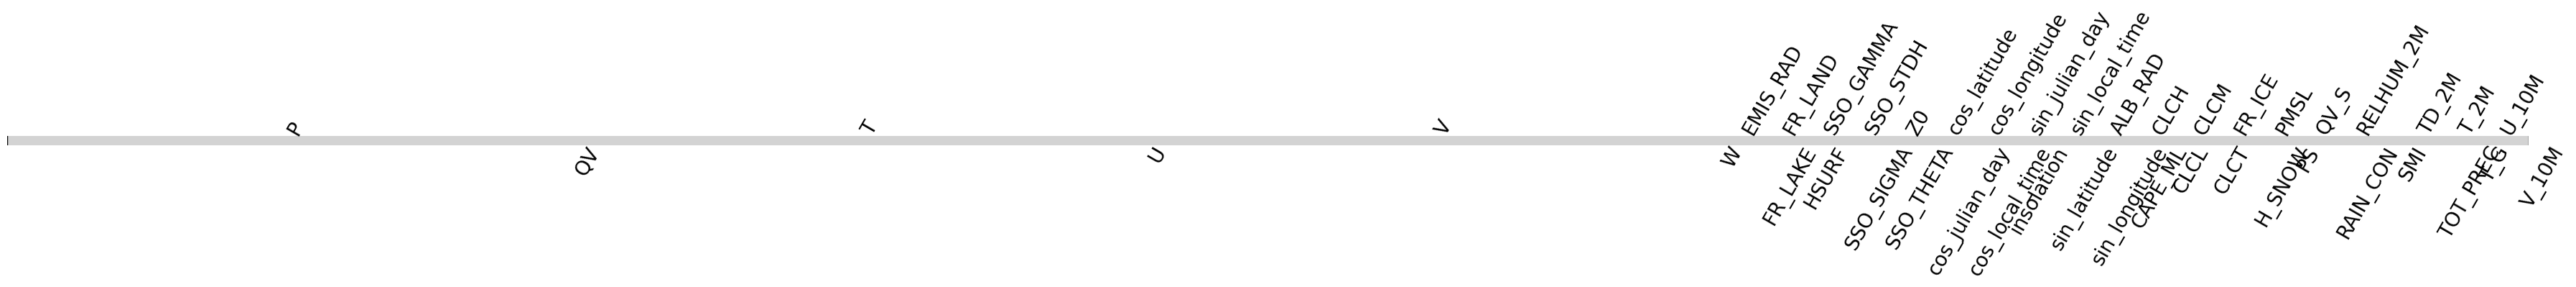

In [38]:
fig, ax = plt.subplots(figsize=(36, 3))
ax.set_frame_on(False)

ax.barh(0, vec_len, height=1.75, color="lightgray", edgecolor="k")

for i, (name, idx) in enumerate(sorted_vars):
    y = 0.05 if i % 2 == 0 else -0.1  # even above, odd below
    va = "bottom" if i % 2 == 0 else "top"
    ax.text(idx + 0.5, y, name, rotation=60, ha="left", va=va, fontsize=20)

ax.set_xlim(0, vec_len)
ax.set_ylim(-0.15, 0.15)
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)

plt.tight_layout()
plt.show()


### Encoder and decoder graph

This section discusses the AICON encoder and decoder. Short recap: The encoder and decoder transform raw node and edge features - ICON cell data - into latent representations, and vice versa.

More generally speaking, the Graph Neural Network encoder and decoder are based on a **bipartite graph**. In a bipartite graph, nodes are divided into two disjoint sets, and edges only connect nodes from different sets - not within the same set.

In PyTorch Geometric (PyG), the bipartite graph is defined by explicitly separating source and target node feature matrices and by using an edge index that connects nodes from the source set to nodes in the target set. For visualization, we transform the AICON/Anemoi bipartite encoder graph into a `NetworkX` graph data structure.

In [39]:
encoder = trainer.model.model.model.encoder

import torch
import networkx as nx

edge_index = encoder.edge_index_base # [2, num_edges]
num_data   = torch.unique(edge_index[0,:]).shape[0]
num_hidden = torch.unique(edge_index[1,:]).shape[0]
print(f"{num_data=}, {num_hidden=}")

G = nx.DiGraph()
G.add_nodes_from(range(num_data), bipartite=0)  # Source set
G.add_nodes_from(range(num_data, num_data + num_hidden), bipartite=1)  # Target set

edges = [(int(edge_index[0, i]),int(edge_index[1, i]) + num_data) for i in range(edge_index.size(1))]
G.add_edges_from(edges)

num_data=11520, num_hidden=5762


The **encoder graph** for AICON is defined by the ICON grid topology: Every data node is connected to the hidden mesh vertices that are given by the cell-to-vertex relationship. Therefore every data point is connected to exactly 3 hidden mesh nodes. Note that the **decoder graph** is defined as the transpose of this mapping.

In [40]:
print(f"maximum degree of source nodes: {max( dict(G.degree(range(num_data))).values() )}")

maximum degree of source nodes: 3


Be aware of the fact that the reverse statement is not true:

In [41]:
print(f"overall maximum degree of encoder graph: {max( dict(G.degree()).values() )}")

overall maximum degree of encoder graph: 6


Since every data point is connected to three vertices of the hidden mesh we can calculate the total number of encoder edges as follows:

In [42]:
n = getattr(netcdf_grid, 'grid_root')
k = cfg.graph.nodes.icon_mesh.node_builder.max_level_multimesh

ncells = 20 * n**2 * 4**k
nedges = 3*ncells # each cell is connected to 3 vertices
print(f"{nedges=}")

nedges=34560


The following plot illustrates how multiple data points are mapped to the latent representation on the coarse hidden mesh. We restrict the graph to the first few edges for better visualization.

In [43]:
nodes_subset = [edge[0] for edge in edges[0:25]]
# add the edge neighbors of any of these nodes to node_subset:
nodes_subset = set(nodes_subset)
for node in nodes_subset.copy():
    neighbors = list(G.neighbors(node))
    nodes_subset.update(neighbors) 
    
G_sub = nx.DiGraph(G.subgraph(nodes_subset))

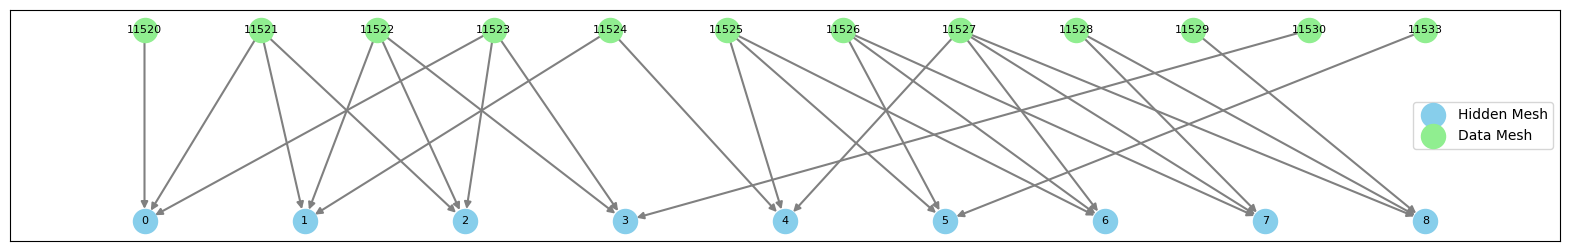

In [44]:
plt.figure(figsize=(20, 3))

# Get the two node sets (if not already known)
nodes_top = {n for n, d in G_sub.nodes(data=True) if d['bipartite'] == 0}
nodes_bottom = set(G_sub) - nodes_top
pos = nx.bipartite_layout(G_sub, nodes_top, align='horizontal')

top = nx.draw_networkx_nodes(G_sub, pos, nodelist=nodes_top, node_color='skyblue')
bottom = nx.draw_networkx_nodes(G_sub, pos, nodelist=nodes_bottom, node_color='lightgreen')
nx.draw_networkx_edges(
    G_sub, pos, arrowstyle='<|-', arrowsize=10, edge_color='gray', width=1.5)
nx.draw_networkx_labels(G_sub, pos, font_size=8)

plt.legend([top, bottom], ['Hidden Mesh', 'Data Mesh'])
plt.show()

In the above illustration we have selected a subset of the bipartite encoder graph `encoder.edge_index` in order to simplify the illustration, the so-called **1-hop induced subgraph**. It is worth noting that the Anemoi MessagePassing GNN uses a similar method to parallelize a model over multiple GPUs: This procedure is called **edge sharding** and calls the function [`bipartite_subgraph`](https://pytorch-geometric.readthedocs.io/en/2.4.0/_modules/torch_geometric/utils/subgraph.html) from the `torch_geometric` package. Every GPU then operates on this subset of encoder edges only.

For our example configuration, however, we have chosen a non-parallel (single-GPU) training. This is indicated by the YAML file setting:

In [45]:
cfg.hardware.num_gpus_per_model

1

### GNN Processor

We will now describe the GNN processor from AICON. The processor in encoder-processor-decoder networks iteratively refines encoded features before decoding.

In AICON, the processor is an unmodified component of the `anemoi-models` package.
Many details of its `torch_geometric` implementation also apply to the encoder and decoder module, which is why we kept the description rather short.

As explained above, the processor operates on a hidden or multi-mesh graph consisting of long-range and short-range edges. We visualize a small part of this graph by plotting the neighbors and neighbors' neighbors of the North Pole.

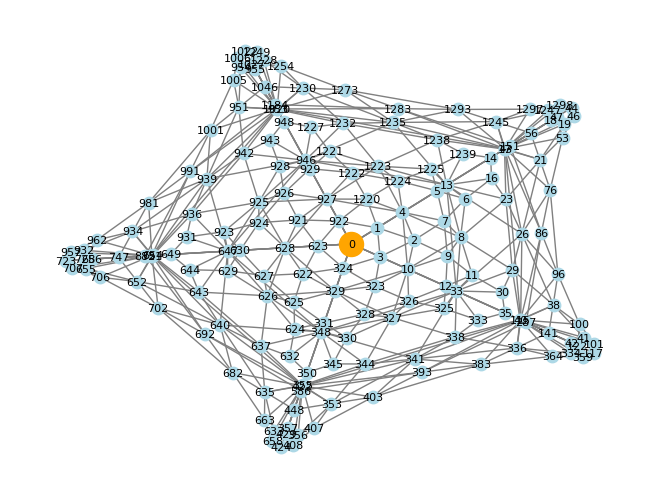

In [46]:
target_node = 0  # arbitrary node index; here: pole

# ----------------------------------------------

import networkx as nx
edges = trainer.graph_data.edge_stores[0].edge_index.numpy()
edge_list = list(zip(edges[0], edges[1]))
G = nx.Graph(edge_list)

first_neighbors = set(G.neighbors(target_node))
second_neighbors = set()
for n in first_neighbors:
    second_neighbors.update(G.neighbors(n))
nodes_to_plot = set([target_node]) | first_neighbors | second_neighbors

subgraph = G.subgraph(nodes_to_plot)
pos = nx.spectral_layout(subgraph)

nx.draw(subgraph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=80, font_size=8)
nx.draw_networkx_nodes(subgraph, pos, nodelist=[target_node], node_color='orange')  # highlight target node

plt.show()

First, we investigate the class hierarchy of the Encoder-Processor-Decoder object that was explained in the overview.
The processor is actually a composition of objects.

In [47]:
ModelEncProcDec = trainer.model.model.model

print(f"Encoder-Processor-Decoder object: {get_class_name(ModelEncProcDec)}")

objects = [
"ModelEncProcDec",
"ModelEncProcDec.processor",
"ModelEncProcDec.processor.proc[0]",
"ModelEncProcDec.processor.proc[0].blocks[0]",
"ModelEncProcDec.processor.proc[0].blocks[0].conv",
]

Encoder-Processor-Decoder object: anemoi.models.models.encoder_processor_decoder.AnemoiModelEncProcDec


The following lists the data types which correspond to this composition of objects:

In [48]:
data = {
    'Object': objects,
    'Class (in this example)':  [get_class_name(eval(obj)) for obj in objects],
}

import pandas as pd
from IPython.display import display
display( pd.DataFrame(data).style.set_table_styles(pandas_table_style) )

,Object,Class (in this example)
0,ModelEncProcDec,anemoi.models.models.encoder_processor_decoder.AnemoiModelEncProcDec
1,ModelEncProcDec.processor,anemoi.models.layers.processor.GraphTransformerProcessor
2,ModelEncProcDec.processor.proc[0],anemoi.models.layers.chunk.GraphTransformerProcessorChunk
3,ModelEncProcDec.processor.proc[0].blocks[0],anemoi.models.layers.block.GraphTransformerProcessorBlock
4,ModelEncProcDec.processor.proc[0].blocks[0].conv,anemoi.models.layers.conv.GraphTransformerConv


We now concentrate on the innermost block of the processor. 

The `GraphTransformerConv` (Graph Attention Network) or the more basic `GraphConv` (Message Passing Neural Network) constitute the interface to the `torch_geometric` package.

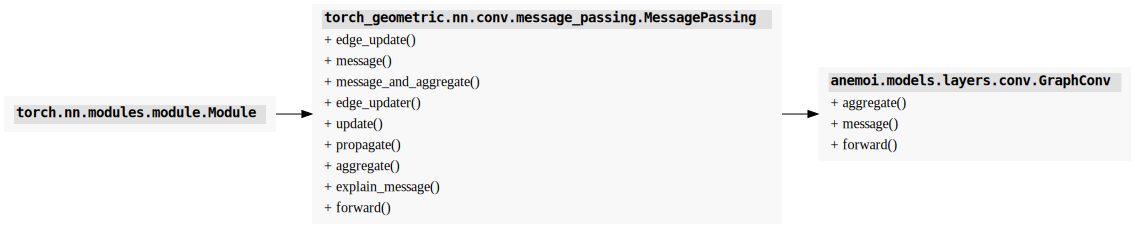

In [49]:
shortlist = {'forward', 'edge_updater', 'edge_update', 'update', 'aggregate', 'message_and_aggregate', 'propagate', 'message', 'explain_message'}

from jupyter_utils import class_to_graphviz
class_to_graphviz(anemoi.models.layers.conv.GraphConv, shortlist=shortlist)

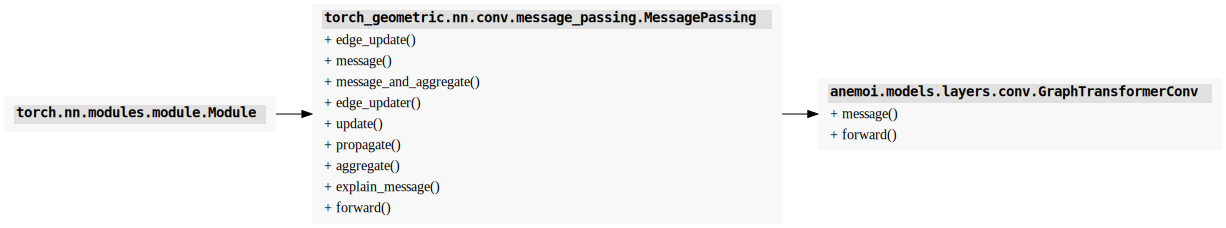

In [50]:
class_to_graphviz(anemoi.models.layers.conv.GraphTransformerConv, shortlist)

The `propagate()` function in PyTorch Geometric is the core message-passing mechanism for GNNs, handling neighbor aggregation and node updates. 
Sparse matrix operations in its implementation avoid explicit loops over individual nodes/edges.

The mathematical expression for the `propagate()` function of the **MessagePassing GNN** is as follows:

$$
\begin{align*}
 x_i' = \gamma_{\Theta} \bigl(x_i, \bigoplus_{j \in \mathcal{N}(i)} \phi_{\Theta}(x_i,x_j,e_{j,i}) \bigr)
\end{align*}
$$

where
- $i$: refers to a *target node*.
- $\mathcal{N}(i)$: neighborhood of node $i$
- $x_i$: node features
- $e_{j,i}$: edge features
- $\oplus$: aggregation scheme: sum, mean, or max operation
- $\gamma$: `update()` function
- $\phi$: `message()` function
- $\theta$ refers to the set of learnable parameters (weights)

An alternative formulation for "message" aggregation mechanism is that each node’s new features become a weighted average of its neighbors’ features. Mathematically this is equivalent to multiplying node features by the normalized adjacency matrix.

In contrast to this, the mathematical formulation for the `propagate()` function of the **GraphTransformer GNN** [Shi2021] is as follows:

$$
\begin{align*}
 x_i' = W_1 x_i + \sum_{j \in \mathcal{N}(i)} \alpha_{i,j} W_2 x_j
\end{align*}
$$

where
- $\alpha_{i,j}$: attention coefficients
- $W_k$: learnable parameters (weights)

This means that a multi-head attention matrix $ \alpha_{i,j}$ replaces the original normalized adjacency matrix as transition matrix for message passing.

The self attention matrix $\alpha$ is defined as

$$
\begin{align*}
 \alpha_{i,j} = \textrm{softmax} \Bigl[ \frac{K_j^T Q_i}{\sqrt{d}} \Bigr]
\end{align*}
$$

where
- $d$: number of channels.
- $Q$,  $K$: queries, keys of the attention mechanism
- the $\textrm{softmax}$ function is a smooth and differentiable transformation function, commonly used in ML architectures.


![Graph Transformer details](_static/graph_transformer_details.png)

For multi-head attention, the outputs of multiple self-attention mechanisms are vertically concatenated. The dimension must be divisible by number of heads.

In [51]:
print(f"{cfg.model.encoder.num_heads=}")

cfg.model.encoder.num_heads=16


### Attention Graph

We now take a closer look at the attention matrix of the  GraphTransformer GNN. Can we visualize the attention that the target node `i` pays to the input `j`?

To this end, we apply a trick and wrap the `message()` function to capture the attention matrix (this programming technique is called *Monkeypatching*). The corresponding code for the attention matrix has been taken from the original implementation [`src/anemoi/models/layers/conv.py`](https://github.com/ecmwf/anemoi-models/blob/develop/src/anemoi/models/layers/conv.py). Arguments with the `_j` and `_i` suffixes correspond to the source and target node for each edge, respectively.

In [52]:
import types
import functools
from torch_geometric.utils import softmax

model = trainer.model.model.model.processor.proc[0].blocks[0].conv
original_message_function = type(model).message

@functools.wraps(original_message_function)
def message_with_attention_matrix(self, heads, query_i, key_j, value_j, edge_attr, index, ptr, size_i):
    global alpha
    if edge_attr is not None:
        key_j = key_j + edge_attr
    alpha = (query_i * key_j).sum(dim=-1) / self.out_channels**0.5
    # the index argument provides, for each edge, the index of the node that will receive the message
    alpha = softmax(alpha, index, ptr, size_i)
    return original_message_function(self, heads, query_i, key_j, value_j, edge_attr, index, ptr, size_i)

model.message = types.MethodType(message_with_attention_matrix, model)

Afterwards, we do a single inference step and record the attention matrix:

In [53]:
alpha = None
input_tensor_torch = torch.ones(shape).half()
with torch.no_grad():
    out = trainer.model.predict_step(input_tensor_torch)

Now, the `alpha` tensor contains the attention for each edge from `j` to `i`.
We can try to interpret the attention matrix for a given target node.

For preparation, we create the hidden mesh as a directed graph with edges and attributes:

In [54]:
import networkx as nx
edges = trainer.graph_data.edge_stores[0].edge_index.numpy()
edge_list = list(zip(edges[0], edges[1]))

edges_with_attrs = []
for i, (u, v) in enumerate(edge_list):
    attr_dict = {
        "global_idx": i,
        "coords": coords[[u,v], :],
        "weight": alpha[i,:]
    }
    edges_with_attrs.append((u, v, attr_dict))

G = nx.DiGraph()
G.add_edges_from(edges_with_attrs)

Then we select a subgraph for a given target node. We select the target node at random. Let's use it as an example to examine the attention weights in more detail:

In [55]:
target_node = 500 # some arbitrary node index
subgraph = G.edge_subgraph(list(G.in_edges(target_node)))

print(f"coords = {coords[target_node]} (lat/lon)")

coords = [ 41.424156 128.90453 ] (lat/lon)


The attention weights of all edges with `target_node` as receiver add to 1 for each of the heads:

In [56]:
head = 4 # some arbitrary head index
sum([w[head] for u, v, w in subgraph.edges(data="weight")])

tensor(1.0000)

The `weight` values, ie. the attention coefficients, represent the relative importance of neighbor j to node i when updating i's features.
Before plotting the attention coefficients we enhance the relative difference between the weights:

In [57]:
draw_weights = np.array([w[head] for u, v, w in subgraph.edges(data="weight")])

draw_weights = draw_weights**4
draw_weights = 5.e1*draw_weights/draw_weights.sum()

draw_weight_dict = {edge: val for edge, val in zip(subgraph.edges, draw_weights)}
nx.set_edge_attributes(subgraph, draw_weight_dict, "draw_weight")

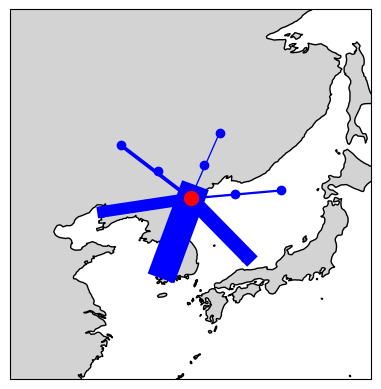

In [58]:
import cartopy.feature as cfeature

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor='lightgray')

d_lon = d_lat = 15
tlat, tlon = coords[target_node]

ax.set_extent([tlon - d_lon, tlon + d_lon, tlat - d_lat, tlat + d_lat])

# Plot each line
for u, v, attrs in subgraph.edges(data=True):
    line = attrs["coords"]
    plt.plot(line[:,1], line[:,0],
             color='blue', linewidth=attrs["draw_weight"], 
             marker='o',
             transform=ccrs.Geodetic())
ax.plot(tlon, tlat,
        marker='o', color='red', markersize=10,
        transform=ccrs.PlateCarree(), label='Receiver Point')
plt.show()

 The above example graph visualizes which nodes are influencing each other.
 Interpreting the attention matrices this way helps understanding how the model determines the importance of relationships between nodes across the graph.

### Transfer learning

Let's take an excursion and create a second AICON setup. The only difference will be a finer, hidden multi-mesh.

In [59]:
config.graph.nodes.icon_mesh.node_builder.max_level_multimesh = 4

trainer_new = AnemoiTrainer(config)
trainer_new.strategy = JupyterNotebookStrategy("auto")

If we try to initialize the new ML model with the weight coefficients of the previous training model, we find that not all field sizes match:

In [60]:
%%capture
ckpt_file_old = f"{cfg.hardware.paths.checkpoints}{trainer.run_id}/last.ckpt"
ckpt_old = torch.load(ckpt_file_old, map_location='cpu', weights_only=False)

model_state_dict = trainer_new.model.state_dict()
state_dict = ckpt_old["state_dict"]

# First loop: collect shapes for matching keys
shapes = {
    key: (state_dict[key].shape, model_state_dict[key].shape)
    for key in state_dict if key in model_state_dict
}

Seed set to 42000


In [61]:
# print mismatches:
for key, (shape_old, shape_new) in shapes.items():
    if shape_old != shape_new:
        print(
            f"Mismatch loading parameter: {key}\n"
            f"  Checkpoint shape: {shape_old}\n"
            f"  Model shape:      {shape_new}\n"
        )

Mismatch loading parameter: model.model.node_attributes.latlons_icon_mesh
  Checkpoint shape: torch.Size([5762, 4])
  Model shape:      torch.Size([23042, 4])

Mismatch loading parameter: model.model.node_attributes.latlons_hidden
  Checkpoint shape: torch.Size([5762, 4])
  Model shape:      torch.Size([23042, 4])

Mismatch loading parameter: model.model.node_attributes.trainable_tensors.icon_mesh.trainable
  Checkpoint shape: torch.Size([5762, 8])
  Model shape:      torch.Size([23042, 8])

Mismatch loading parameter: model.model.node_attributes.trainable_tensors.hidden.trainable
  Checkpoint shape: torch.Size([5762, 8])
  Model shape:      torch.Size([23042, 8])



In the list of model attributes, we see some incompatible, grid-dependent vectors.
As one might have expected, these are the node coordinates of the hidden mesh, as well as the trainable features mentioned briefly earlier. These node and edge attributes are treated as free parameters and updated during training.
However, all other model weights can be applied to the new mesh, despite its higher spatial resolution.

As long as the new graph's higher resolution preserves the training graph's essential structural and statistical properties, the GNN’s learned weights can effectively process and propagate information.
In other words, this is a type of "knowledge transfer" or **transfer learning** between problems. For example, it allows for the organization of a cost-efficient training schedule.

In [62]:
import logging
import anemoi.training.train.train

console_handler = logging.StreamHandler()  # By default, outputs to console
formatter = logging.Formatter('%(levelname)s: %(message)s')
console_handler.setFormatter(formatter)
logging.getLogger("anemoi.training.train.train").addHandler(console_handler)
anemoi.training.train.train.LOGGER.setLevel(logging.INFO)

config_new = config.copy()
config_new.training.load_weights_only = True
config_new.training.transfer_learning = True
config_new.training.run_id = trainer.run_id

trainer_new = AnemoiTrainer(config_new)
trainer_new.strategy = JupyterNotebookStrategy("auto")

trainer_new.train()

INFO: Config validated.
INFO: Starting from checkpoint: True
INFO: Run id: 0210d057-147f-4d04-8d3f-df4b50044024
INFO: Checkpoints path: output_training/checkpoint/0210d057-147f-4d04-8d3f-df4b50044024
INFO: Plots path: output_training/mrl3/plots/0210d057-147f-4d04-8d3f-df4b50044024
INFO: Number of data variables: 123
INFO: Variables: ['P_101', 'P_108', 'P_112', 'P_119', 'P_120', 'P_49', 'P_57', 'P_64', 'P_70', 'P_75', 'P_79', 'P_86', 'P_91', 'P_96', 'QV_101', 'QV_108', 'QV_112', 'QV_119', 'QV_120', 'QV_49', 'QV_57', 'QV_64', 'QV_70', 'QV_75', 'QV_79', 'QV_86', 'QV_91', 'QV_96', 'T_101', 'T_108', 'T_112', 'T_119', 'T_120', 'T_49', 'T_57', 'T_64', 'T_70', 'T_75', 'T_79', 'T_86', 'T_91', 'T_96', 'U_101', 'U_108', 'U_112', 'U_119', 'U_120', 'U_49', 'U_57', 'U_64', 'U_70', 'U_75', 'U_79', 'U_86', 'U_91', 'U_96', 'V_101', 'V_108', 'V_112', 'V_119', 'V_120', 'V_49', 'V_57', 'V_64', 'V_70', 'V_75', 'V_79', 'V_86', 'V_91', 'V_96', 'W_101', 'W_108', 'W_112', 'W_119', 'W_120', 'W_49', 'W_57', 'W_6

┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                 ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ AnemoiModelInterface │  719 K │ train │     0 │
│ 1 │ loss    │ WeightedMSELoss      │      0 │ train │     0 │
│ 2 │ metrics │ ModuleDict           │      0 │ train │     0 │
└───┴─────────┴──────────────────────┴────────┴───────┴───────┘

Trainable params: 719 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 719 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 102                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/shared/data/fprill/aicon_walkthrough/venv/src/anemoi-training/training/src/anemoi/training/losses/scaler_tensor.py:553: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:355.)
  x_subset = x[subset_indices] if subset_indices is not None else x
/shared/data/fprill/aicon_walkthrough/venv/src/anemoi-training/training/src/anemoi/training/losses/scaler_tensor.py:576: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered 

## Running the DWD inference tool

This final section describes the **[AICON Anemoi Inference](https://gitlab.dkrz.de/dwd-ki-zentrum/apps/aicon-anemoi)** inference program.
This is not Anemoi's "official" tool for running the trained model, but it is a custom implementation by DWD aiming towards operational application.
It differs from the existing Anemoi package `anemoi-inference` in terms of code length, special GRIB2 handling, and preprocessing capabilities, including the aggregation of the soil moisture and the recomputation of the soil moisture index SMI. The program is packaged into a container as part of the AICON operational setup.

In [63]:
%%capture
!git clone -b aicon_walkthrough git@gitlab.dkrz.de:dwd-ki-zentrum/apps/aicon-anemoi.git
!cd aicon-anemoi && pip install -U -e .

The inference tool `aicon-inference` is a command-line utility with various options:

In [64]:
!aicon-inference --help

usage: aicon-inference [-h] [--version] [--cfg CFG] [--print_config[=flags]]
                       [--checkpoint CHECKPOINT] [--grid_file GRID_FILE]
                       [--extpar_file EXTPAR_FILE] [--invar_file INVAR_FILE]
                       [--ana_files_date0 ANA_FILES_DATE0]
                       [--ana_files_date1 ANA_FILES_DATE1]
                       [--forecast_time FORECAST_TIME] [--initialstate]
                       [--grib_output [GRIB_OUTPUT]]
                       [--post_processor POST_PROCESSOR]
                       [--derive_variables DERIVE_VARIABLES]
                       [--accumulate ACCUMULATE]
                       [--use_deterministic_algorithms]

slim inference script for anemoi-core created model checkpoints.

options:
  -h, --help            show this help message and exit
  --version             show program's version number and exit
  --cfg CFG             Path to a configuration file. (default: None)
  --print_config[=flags]
                 

We need some example data which we download from a server.

In [65]:
download_data = not os.path.isdir("test_data_aicon_inference") # download data only if it does not exist

if download_data:
  !wget -r -H -N --cut-dirs=2 --content-disposition -I "/v1/" "https://swiftbrowser.dkrz.de/tcl_objects/2025-12-22T09:12:15Z/r_429459c3a284c7e843711ff5232dc81d2629ada4/w_/dkrz_e1060ac3d73b4204911afddb3bd7fc61/test_data_aicon_inference/0/?show_all"
  !tar xvzf swift.dkrz.de/test_data_aicon_inference/test_data_aicon_inference.tar.gz

Especially the composition of the input tensor is a complex process that is conveniently handled by the inference tool. Arguments are provided via a YAML config file. A complete example call of the command line tool would look like this:

In [66]:
ckpt = f"{cfg.hardware.paths.checkpoints}/{trainer.run_id}/inference-last.ckpt"
%env CHECKPOINT={ckpt}

env: CHECKPOINT=output_training/checkpoint//0210d057-147f-4d04-8d3f-df4b50044024/inference-last.ckpt


In [67]:
f = open("inference_test01.yaml", 'w')
f.write(
"""
grid_file: test_data_aicon_inference/icon_grid_0026_R03B07_G.nc
extpar_file: test_data_aicon_inference/icon_extpar_0026_R03B07_G_20231113_tiles.g2
ana_files_date0: 
  - test_data_aicon_inference/an_R03B07.2024083121
  - test_data_aicon_inference/fc_R03B07.2024083121
ana_files_date1: 
  - test_data_aicon_inference/an_R03B07.2024090100
  - test_data_aicon_inference/fc_R03B07.2024090100
forecast_time: 12
grib_output:
  - filename_format: icon_output_0026_R03B07_G_{date:%Y%m%d%H}.grib2
    template: test_data_aicon_inference/AICON_template.MLPL.grib2
    additional_keys:
      localNumberOfExperiment: 1
      generatingProcessIdentifier: 1
post_processor:
  in_place: no
initialstate: yes
"""
)
f.close()

In [68]:
!aicon-inference --checkpoint $CHECKPOINT --cfg "inference_test01.yaml"

Calculate soil moisture index (SMI) for 2024-08-31T21:00
  index 0: min=-0.7218013627629448 max=2.0
  index 1: min=-0.3260916742149758 max=2.0
Calculate soil moisture index (SMI) for 2024-09-01T00:00
  index 0: min=-0.7609507736650485 max=2.0
  index 1: min=-0.3260916742149758 max=2.0
output initial state
predicting step 1/2 2024-09-01T00:00
predicting step 2/2 2024-09-01T06:00
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  23471 KiB | 288681 KiB |   2484 MiB |   2462 M

Internally, the inference script (asynchronously) takes care of the GRIB I/O. 
For example, it reads the forcing fields, that provide external information to the model but are not predicted by the model itself. The inference checkpoint define a precise list of these fields:

In [69]:
checkpoint = f"{cfg.hardware.paths.checkpoints}/{trainer.run_id}/inference-last.ckpt"

# extract meta-data from checkpoint:
import zipfile, json
with zipfile.ZipFile(checkpoint, "r") as f:
    json_file = next((s for s in f.namelist() if os.path.basename(s) == "ai-models.json"), None)
    metadata = json.load(f.open(json_file, "r"))
    
variables = metadata["dataset"]["variables"]
indices_from = metadata["data_indices"]["data"]["input"]["full"]
indices_to = metadata["data_indices"]["model"]["input"]["full"]
mapping = dict({i: j for i, j in zip(indices_from, indices_to)})

# forcing variables:
[variables[mapping[i]] for i in metadata["data_indices"]["model"]["input"]["forcing"]]

['EMIS_RAD',
 'FR_LAKE',
 'FR_LAND',
 'HSURF',
 'SSO_GAMMA',
 'SSO_SIGMA',
 'SSO_STDH',
 'SSO_THETA',
 'Z0',
 'cos_julian_day',
 'cos_latitude',
 'cos_local_time',
 'cos_longitude',
 'insolation',
 'sin_julian_day',
 'sin_latitude',
 'sin_local_time',
 'sin_longitude']


In this list, the forcing variables are supplemented by so-called time-dependent *dynamic forcings*, currently `["cos_julian_day", "sin_julian_day", "cos_local_time", "sin_local_time", "insolation"]`. 
Let's assume now that such an input dataset has been loaded into memory:

In [70]:
input_tensor_torch = torch.ones(shape)

Then, basically, the inference script repeatedly applies the following step to reach the desired forecast lead time:

In [71]:
torch.set_grad_enabled(False)
with torch.no_grad():
    # Run the model in inference mode
    out = trainer.model.predict_step(input_tensor_torch)

Finally, we generate a sample plot of our test prediction:

In [72]:
import torch
from matplotlib.tri import Triangulation
import earthkit.data as ekd
model = torch.load(checkpoint, map_location="cpu", weights_only=False)
lat = model.graph_data["data"].x[:, 0].cpu().numpy()
lon = model.graph_data["data"].x[:, 1].cpu().numpy()

In [73]:
field = ekd.from_source("file", "icon_output_0026_R03B07_G_2024090100_cli.grib2").sel(shortName="P", level=10)

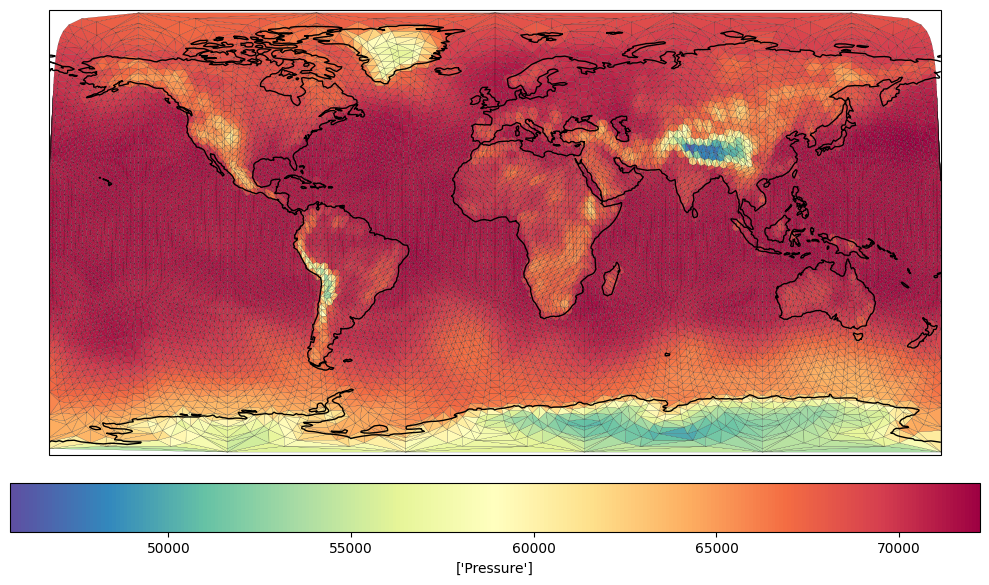

In [74]:
import numpy as np
import cartopy.crs as ccrs

tri = Triangulation(np.rad2deg(lon), np.rad2deg(lat))

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_global(); ax.coastlines()
tpc = ax.tripcolor(tri, field.to_numpy().flatten(), cmap="Spectral_r", edgecolors='k', linewidth=0.1, transform=ccrs.PlateCarree())
plt.colorbar(tpc, ax=ax, orientation='horizontal', pad=0.05, label=field.metadata("name"))
plt.tight_layout(); plt.show()

One final remark: The inference tool is capable of directly writing output interpolated onto regular (rotated) latitude-longitude grids. To accomplish this, the necessary interpolation weights can be provided as a YAML config parameter. These weights are pre-calculated using the command-line utility `create_interpolation_weights_icon2reg.py`, utilizing numerical algorithms from the [ICON YAC coupler](https://dkrz-sw.gitlab-pages.dkrz.de/yac/). A detailed list of these algorithms can be accessed [online](https://dkrz-sw.gitlab-pages.dkrz.de/yac/d0/da2/interp_methods.html). You can find the interpolation tool [here](https://gitlab.dkrz.de/dwd-ki-zentrum/infrastructure/yac-python), and it is also available in a containerized version.

The AICON inference script itself has also been bundled as a [Apptainer/Singularity](https://apptainer.org/) software container for operational use. This container is available on the DWD GPU cluster and can be found with the command `module load nwp; cwhence aicon-main.sif`. The necessary constant data can be found in the directory `/hpc/rhome/routfox/routfox/aiglo/aicon`. Note that the NetCDF grid therein is not a "classical" ICON grid file but a grid augmented by additional hierarchy information, see the section on the hidden mesh construction above.

---

## Bibliography

- [DWD2024] 6th WCRP International Conference on Reanalysis. (2024). ICON-DREAM: A new dual resolution reanalysis from DWD [Conference presentation]. https://confit.atlas.jp/guide/event/icr6/subject/OR2-01/detail
- [Keisler2022] Keisler, R. (2022). Forecasting global weather with graph neural networks. arXiv. https://doi.org/10.48550/arXiv.22
- [Lang2024] Lang, S., Alexe, M., Chantry, M., Dramsch, J., Pinault, F., Raoult, B., Clare, M. C. A., Lessig, C., Maier-Gerber, M., Magnusson, L., Ben Bouallègue, Z., Prieto Nemesio, A., Dueben, P. D., Brown, A., Pappenberger, F., & Rabier, F. (2024). AIFS -- ECMWF's data-driven forecasting system (arXiv:2406.01465). arXiv. https://doi.org/10.48550/arXiv.2406.01465
- [Lam2022] Lam, R., Sanchez-Gonzalez, A., Willson, M., Wirnsberger, P., Fortunato, M., Alet, F., Ravuri, S., Ewalds, T., Eaton-Rosen, Z., Hu, W., Merose, A., Hoyer, S., Holland, G., Vinyals, O., Stott, J., Pritzel, A., Mohamed, S., & Battaglia, P. (2022). GraphCast: Learning skillful medium-range global weather forecasting. arXiv. https://arxiv.org/abs/2212.12794
- [Prill2024] Prill, F., Reinert, D., Rieger, D., and Zängl, G.: ICON Tutorial - Working with the ICON model, Deutscher Wetterdienst, Offenbach, https://doi.org/10.5676/DWD_pub/nwv/icon_tutorial2024, 2024.
- [Shi2021] Yunsheng Shi, Zhengjie Huang, Shikun Feng, Hui Zhong, Wenjin Wang, Yu Sun: Masked Label Prediction: Unified Message Passing Model for Semi-Supervised Classification. 2021, https://arxiv.org/abs/2009.03509